In [1]:
import numpy as np
import pandas as pd

from IPython.display import display, display_html , HTML

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_prf = pd.read_excel('data/dataset10anos.xlsx')

In [2]:
df_prf = pd.read_json("data/acidentes2017-2023.json")

In [3]:
df_prf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977884 entries, 0 to 977883
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   data_inversa            977884 non-null  object
 1   dia_semana              977884 non-null  object
 2   horario                 977884 non-null  object
 3   uf                      977884 non-null  object
 4   br                      977884 non-null  int64 
 5   km                      977884 non-null  object
 6   municipio               977884 non-null  object
 7   causa_acidente          977884 non-null  object
 8   tipo_acidente           977884 non-null  object
 9   classificacao_acidente  977884 non-null  object
 10  fase_dia                977884 non-null  object
 11  sentido_via             977884 non-null  object
 12  condicao_metereologica  977884 non-null  object
 13  tipo_pista              977884 non-null  object
 14  tracado_via             977884 non-n

In [4]:
df_prf.head()

,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,...,idade,sexo,marca_veiculo,modelo_veiculo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude
0,2017-01-01,domingo,01:45:00,RS,116,"34,9",vacaria,defeito_mecanico_no_veiculo,colisao_traseira,com_vitimas_feridas,...,31,masculino,VW,17.280 CRM 4X2 4P,1,0,0,0,"-28,5071196","-50,941176"
1,2017-01-01,domingo,01:00:00,PR,376,636,tijucas_do_sul,velocidade_incompativel,saida_de_leito_carrocavel,com_vitimas_fatais,...,28,masculino,M.BENZ,ATEGO 2430,1,0,0,0,"-25,754","-49,1266"
2,2017-01-01,domingo,04:40:00,BA,101,65,entre_rios,condutor_dormindo,colisao_frontal,com_vitimas_fatais,...,53,masculino,SCANIA,G 380 A4X2,1,0,0,0,"-11,9618","-38,0953"
3,2017-01-01,domingo,07:40:00,RN,405,30,mossoro,ingestao_de_alcool,colisao_frontal,com_vitimas_fatais,...,44,masculino,SCANIA,R 480 A6X4,1,0,0,0,"-5,3136","-37,569"
4,2017-01-01,domingo,10:35:00,PR,376,"249,5",apucarana,nao_guardar_distancia_de_seguranca,colisao_traseira,com_vitimas_feridas,...,56,masculino,FORD,CARGO 1723,1,0,0,0,"-23,61073749","-51,39895052"


In [5]:
from sklearn.preprocessing import LabelEncoder

def is_within_brazil(lat, lon):
    return -33.7422 <= lat <= 5.2718 and -73.989 <= lon <= -34.793

def encoding(df):
    label = LabelEncoder()
    for c in df.select_dtypes("object"):
        df[c] = df[c].astype(str)
        df[c]=label.fit_transform(df[c])
    return df

def imputation(df):
    df = df.fillna(df.median())
    df = df.dropna()
    return df

def preprocessing(df):
    df = encoding(df)
    df = imputation(df) 

    return df


def calcular_gravidade(row):
    if row['ilesos'] == 1:
        return 1
    elif row['feridos_leves'] == 1:
        return 2
    elif row['feridos_graves'] == 1:
        return 3
    elif row['mortos'] == 1:
        return 4
    else:
        return 0


In [6]:
df_prf['longitude'] = df_prf['longitude'].str.replace(",", ".").astype(float).round(6)
df_prf['latitude'] = df_prf['latitude'].str.replace(",", ".").astype(float).round(6)

df_prf = df_prf[df_prf.apply(lambda row: is_within_brazil(row['latitude'], row['longitude']), axis=1)]

In [7]:
df_prf['gravidade'] = df_prf.apply(calcular_gravidade, axis=1)
df_prf = df_prf[df_prf['gravidade'] != 0]

In [8]:
df_prf['fase_dia'] = df_prf['fase_dia'].map({
1 : 'plena_noite',
2 : 'amanhecer',
3 : 'pleno_dia',
4 : 'anoitecer'
})

df_prf['condicao_metereologica'] = df_prf['condicao_metereologica'].map({
1 : 'ceu_claro',
2 : 'vento',
3 : 'sol',
4 : 'nublado',
5 : 'garoa_chuvisco',
6 : 'chuva',
7 : 'nevoeiro_neblina',
8 : 'granizo',
9 : 'neve'})

df_prf['tipo_acidente'] = df_prf['tipo_acidente'].map({
1 : 'colisao_traseira',
2 : 'saida_de_leito_carrocavel',
3 : 'colisao_frontal',
4 : 'colisao_lateral',
5 : 'tombamento',
6 : 'colisao_com_objeto_em_movimento',
7 : 'derramamento_de_carga',
8 : 'atropelamento_de_pedestre',
9 : 'colisao_transversal',
10 : 'incendio',
11 : 'capotamento',
12 : 'atropelamento_de_animal',
13 : 'colisao_com_objeto_estatico',
14 : 'engavetamento',
15 : 'danos_eventuais',
16 : 'queda_de_ocupante_de_veiculo',
17 : 'colisao_lateral_sentido_oposto',
18 : 'colisao_com_objeto',
19 : 'colisao_lateral_mesmo_sentido',
20 : 'eventos_atipicos',
})

df_prf['tipo_pista'] = df_prf['tipo_pista'].map({
1 : 'simples',
2 : 'dupla',
3 : 'multipla'
})


In [8]:
df_prf = preprocessing(df_prf)

In [9]:
df_prf["tipo_pista"].value_counts()

tipo_pista
2    513911
0    386060
1     77807
Name: count, dtype: int64

In [10]:
count_class_4, count_class_1, count_class_3, count_class_2 = df_prf['gravidade'].value_counts()

df_class_1 = df_prf[df_prf['gravidade'] == 1]
df_class_2 = df_prf[df_prf['gravidade'] == 2]
df_class_3 = df_prf[df_prf['gravidade'] == 3]
df_class_4 = df_prf[df_prf['gravidade'] == 4]

df_class_1_under = df_class_1.sample(count_class_2,random_state=42)
df_class_4_under = df_class_4.sample(count_class_2,random_state=42)
df_class_3_under = df_class_3.sample(count_class_2,random_state=42)
df_under = pd.concat([df_class_1_under, df_class_2, df_class_3_under, df_class_4_under], axis=0)

df_class_2_over = df_class_2.sample(count_class_1, replace=True, random_state=42)
df_class_3_over = df_class_3.sample(count_class_1, replace=True, random_state=42)
df_class_4_over = df_class_4.sample(count_class_1, replace=True, random_state=42)
df_over = pd.concat([df_class_1, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

In [11]:
df_to_set = df_over.select_dtypes(include=['float64', 'int64', 'int32'])
df_to_set = df_to_set.drop(['classificacao_acidente','ilesos','feridos_leves','feridos_graves', 'mortos', 'estado_fisico', 'marca'], axis=1)

Text(0.5, 1.0, 'TestSet')

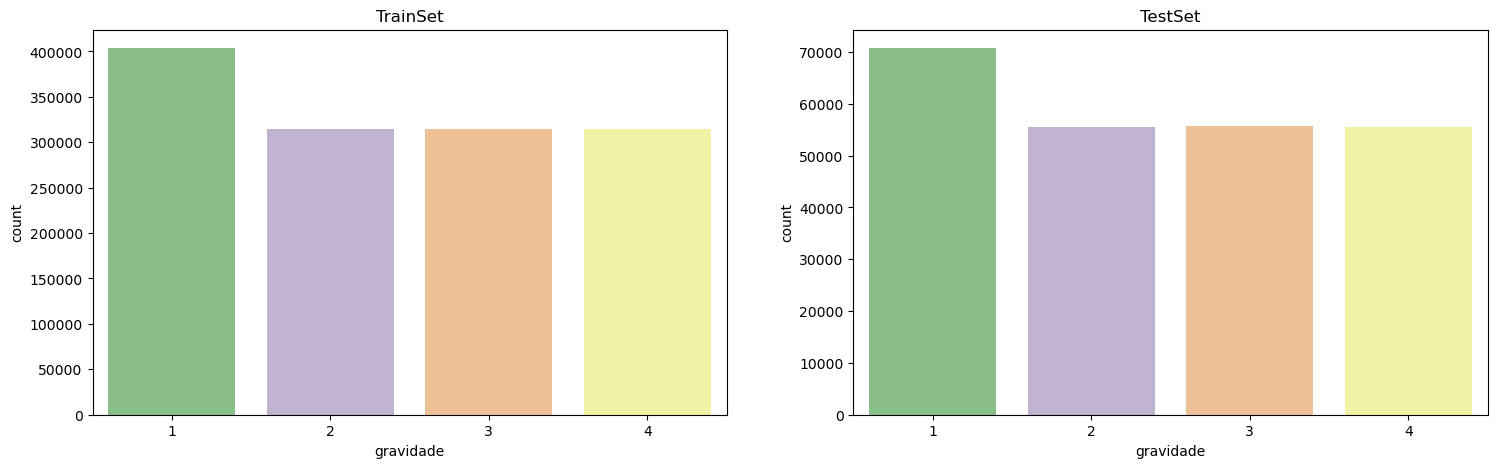

In [12]:
trainset, testset = train_test_split(df_to_set, test_size=0.15, random_state=42)
fig, ax = plt.subplots(1,2, figsize=(18, 5))
sns.countplot(x = 'gravidade' , data = trainset,ax=ax[0],palette="Accent").set_title('TrainSet')
sns.countplot(x = 'gravidade' , data = testset,ax=ax[1],palette="Accent").set_title('TestSet')

In [13]:
X_train = trainset.drop('gravidade',axis=1)
y_train = trainset['gravidade']
X_test = testset.drop('gravidade',axis=1)
y_test = testset['gravidade']

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [15]:
preprocessor = make_pipeline(StandardScaler())

PCAPipeline = make_pipeline(preprocessor, PCA(n_components=3,random_state=0))

RandomPipeline = make_pipeline(preprocessor,RandomForestClassifier(random_state=0))
AdaPipeline = make_pipeline(preprocessor,AdaBoostClassifier(random_state=0))
SVMPipeline = make_pipeline(preprocessor,SVC(random_state=0,probability=True))
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier())
LRPipeline = make_pipeline(preprocessor,LogisticRegression(solver='sag'))

In [16]:
df_to_pca = df_prf.select_dtypes(include=['float64', 'int64', 'int32'])

PCA_df = pd.DataFrame(PCAPipeline.fit_transform(df_to_pca.drop('gravidade',axis=1)))
PCA_df = pd.concat([PCA_df.reset_index(), df_to_pca['gravidade'].map({
                                  1:'ilesos',
                                  2:'feridos_leves',
                                  3:'feridos_graves',
                                  4:'mortos'
                                }).reset_index()], axis=1)
PCA_df = PCA_df.drop(['index'],axis=1)
PCA_df.head()

,0,1,2,gravidade
0,-2.065221,-2.013486,1.799476,ilesos
1,-0.985205,-2.397342,1.132876,ilesos
2,-1.214137,-1.363604,1.810365,ilesos
3,-1.408908,-1.331867,1.472619,ilesos
4,-1.595778,-2.320482,-0.856468,ilesos


In [ ]:
import plotly.express as px

figure1 = px.scatter_3d(PCA_df,
        x=0, 
        y=1, 
        z=2, 
        color = 'gravidade',
                       width=600, height=800)
figure1.update_traces(marker=dict(size=5,
                                  line=dict(width=0.15,
                                        color='black')),
                      selector=dict(mode='markers'))

figure1.show()

In [17]:
dict_of_models = {'KNN': KNNPipeline,
                  'RandomForest': RandomPipeline,
                  'AdaBoost': AdaPipeline,
                  #'SVM': SVMPipeline,
                  'LR': LRPipeline}

In [18]:
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the predictions
    y_pred = model.predict(X_test)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

In [19]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

---------------------------------
KNN
Accuracy =  0.7311440490673582
-
[[47118 10990  8648  4002]
 [13665 28274 10301  3315]
 [ 4842  6061 42759  1965]
 [   20    20    38 55533]]
-
              precision    recall  f1-score   support

           1       0.72      0.67      0.69     70758
           2       0.62      0.51      0.56     55555
           3       0.69      0.77      0.73     55627
           4       0.86      1.00      0.92     55611

    accuracy                           0.73    237551
   macro avg       0.72      0.74      0.73    237551
weighted avg       0.72      0.73      0.72    237551

-
---------------------------------
RandomForest
Accuracy =  0.9132396832680141
-
[[62738  6669  1134   217]
 [ 7946 45060  2287   262]
 [  671  1230 53550   176]
 [    0     0    18 55593]]
-
              precision    recall  f1-score   support

           1       0.88      0.89      0.88     70758
           2       0.85      0.81      0.83     55555
           3       0.94    